In [2]:
# Feature Selection for MLB Pitcher Injury Prediction
# Following a multi-step approach to handle multicollinearity and identify robust predictors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 0: Load and Prepare Data


In [3]:
# Load data
df = pd.read_csv('pitcher_data_w_injuries.csv')

print(f"Data shape: {df.shape}")
print(f"Years in data: {sorted(df['game_year'].unique())}")

# Split into training (2018-2023) and test (2024) sets
train_df = df[df['game_year'].between(2018, 2023)].copy()
test_df = df[df['game_year'] == 2024].copy()

print(f"\nTraining set: {train_df.shape[0]} rows")
print(f"Test set: {test_df.shape[0]} rows")
print(f"\nInjury rate in training: {train_df['injury_next_year'].mean():.3f}")
print(f"Injury rate in test: {test_df['injury_next_year'].mean():.3f}")

# Define feature categories
unmodifiable_features = [
    'birth_country', 'height', 'weight', 'hand', 'age', 'bmi', 'prev_arm_inj_hist'
]

modifiable_features = [
    'num_pitches_thrown', 'num_games', 'num_bf', 'bf_per_game', 'pitches_per_game',
    'pitcher_role', 'hrel_sd', 'vrel_sd',
    'BB%', 'FB%', 'OS%',
    'BB_avg_velo', 'FB_avg_velo', 'OS_avg_velo',
    'BB_avg_hb', 'FB_avg_hb', 'OS_avg_hb',
    'BB_avg_ivb', 'FB_avg_ivb', 'OS_avg_ivb',
    'BB_avg_spin', 'FB_avg_spin', 'OS_avg_spin',
    'BB_avg_ext', 'FB_avg_ext', 'OS_avg_ext',
    'BB_avg_spin_axis', 'FB_avg_spin_axis', 'OS_avg_spin_axis',
    'BB_max_velo', 'FB_max_velo', 'OS_max_velo',
    'BB_max_hb', 'FB_max_hb', 'OS_max_hb',
    'BB_max_ivb', 'FB_max_ivb', 'OS_max_ivb',
    'BB_max_spin', 'FB_max_spin', 'OS_max_spin',
    'BB_max_ext', 'FB_max_ext', 'OS_max_ext',
    'BB_max_spin_axis', 'FB_max_spin_axis', 'OS_max_spin_axis'
]

# Get all delta features (columns starting with Δ)
delta_features = [col for col in df.columns if col.startswith('Δ_')]
delta_features.append('first_year')  # Must be paired with delta features

print(f"\nUnmodifiable features: {len(unmodifiable_features)}")
print(f"Modifiable features: {len(modifiable_features)}")
print(f"Delta features: {len(delta_features)}")


Data shape: (6300, 107)
Years in data: [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

Training set: 4695 rows
Test set: 802 rows

Injury rate in training: 0.201
Injury rate in test: 0.222

Unmodifiable features: 7
Modifiable features: 47
Delta features: 47


## Step 1: Correlation-Based Clustering


In [4]:
def correlation_clustering(features_df, threshold=0.20, method='ward'):
    """
    Perform correlation-based clustering to identify redundant predictors.
    
    Parameters:
    - features_df: DataFrame with features (already standardized)
    - threshold: Distance threshold for cutting dendrogram
    - method: Clustering method ('ward', 'complete', 'average')
    
    Returns:
    - cluster_labels: Dictionary mapping features to cluster IDs
    - dendrogram_data: Data for visualization
    - correlation_matrix: Correlation matrix
    """
    # Compute correlation matrix
    corr_matrix = features_df.corr().abs()
    
    # Convert correlations to distances: d_ij = 1 - |rho_ij|
    distance_matrix = 1 - corr_matrix.values
    
    # Apply hierarchical clustering
    # Note: Ward method requires squared distances, but we'll use complete linkage
    # which works better with correlation distances
    if method == 'ward':
        # For Ward, we need to ensure non-negative distances
        linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='ward')
    else:
        linkage_matrix = linkage(squareform(distance_matrix, checks=False), method=method)
    
    # Cut dendrogram at threshold
    cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')
    
    # Create mapping
    feature_clusters = {}
    for i, feature in enumerate(features_df.columns):
        feature_clusters[feature] = cluster_labels[i]
    
    return feature_clusters, linkage_matrix, corr_matrix

def select_cluster_representatives(features_df, target, cluster_dict):
    """
    Select one representative from each cluster based on:
    1. Univariate predictive strength (correlation with target)
    2. Data completeness (fewer missing values)
    3. Interpretability (prefer simpler features)
    """
    representatives = []
    
    # Get unique clusters
    unique_clusters = set(cluster_dict.values())
    
    for cluster_id in unique_clusters:
        cluster_features = [f for f, c in cluster_dict.items() if c == cluster_id]
        
        if len(cluster_features) == 1:
            representatives.append(cluster_features[0])
        else:
            # Score each feature in cluster
            scores = []
            for feature in cluster_features:
                # Check if feature exists and has data
                if feature not in features_df.columns:
                    continue
                
                # Compute univariate correlation with target
                feature_data = features_df[feature].dropna()
                if len(feature_data) == 0:
                    continue
                
                # Get corresponding target values
                valid_idx = features_df[feature].notna()
                if valid_idx.sum() < 100:  # Need minimum data points
                    continue
                
                target_subset = target[valid_idx]
                feature_subset = features_df.loc[valid_idx, feature]
                
                # Compute absolute correlation
                if feature_subset.std() > 0:
                    corr = abs(np.corrcoef(feature_subset, target_subset)[0, 1])
                else:
                    corr = 0
                
                # Data completeness score
                completeness = valid_idx.sum() / len(features_df)
                
                # Combined score (weighted)
                score = 0.6 * corr + 0.4 * completeness
                scores.append((feature, score, corr, completeness))
            
            if scores:
                # Select feature with highest score
                best_feature = max(scores, key=lambda x: x[1])[0]
                representatives.append(best_feature)
    
    return representatives

print("Correlation clustering functions defined!")


Correlation clustering functions defined!


In [ ]:
# Prepare data for clustering - handle categorical variables
def prepare_features_for_clustering(df, feature_list, target_col='injury_next_year'):
    """
    Prepare features for clustering by:
    1. Handling categorical variables (one-hot encoding)
    2. Standardizing numerical features
    3. Handling missing values
    """
    # Filter to available features
    available_features = [f for f in feature_list if f in df.columns]
    feature_df = df[available_features].copy()
    
    # Separate categorical and numerical
    categorical_features = []
    numerical_features = []
    
    for col in feature_df.columns:
        if feature_df[col].dtype == 'object' or feature_df[col].dtype.name == 'category':
            categorical_features.append(col)
        else:
            numerical_features.append(col)
    
    # One-hot encode categorical features
    if categorical_features:
        feature_df = pd.get_dummies(feature_df, columns=categorical_features, drop_first=True)
    
    # Standardize numerical features
    scaler = StandardScaler()
    if numerical_features:
        feature_df[numerical_features] = scaler.fit_transform(feature_df[numerical_features].fillna(0))
    
    # Fill remaining NaN with 0 (after standardization, mean is 0)
    feature_df = feature_df.fillna(0)
    
    return feature_df, scaler

# Process unmodifiable features
print("Processing unmodifiable features...")
unmod_df, unmod_scaler = prepare_features_for_clustering(
    train_df, unmodifiable_features, 'injury_next_year'
)
print(f"Unmodifiable features after encoding: {unmod_df.shape[1]}")

# Process modifiable + delta features
print("\nProcessing modifiable + delta features...")
mod_features = modifiable_features + delta_features
mod_df, mod_scaler = prepare_features_for_clustering(
    train_df, mod_features, 'injury_next_year'
)
print(f"Modifiable + delta features after encoding: {mod_df.shape[1]}")

# Visualize correlation heatmaps (sample for large feature sets)
if unmod_df.shape[1] <= 20:
    plt.figure(figsize=(10, 8))
    corr_unmod = unmod_df.corr()
    sns.heatmap(corr_unmod, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Unmodifiable Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping correlation heatmap for unmodifiable (too many features)")

# For modifiable features, show correlation of a sample
if mod_df.shape[1] > 50:
    # Sample top 30 most variable features
    feature_vars = mod_df.var().sort_values(ascending=False)
    top_features = feature_vars.head(30).index.tolist()
    plt.figure(figsize=(14, 12))
    corr_mod_sample = mod_df[top_features].corr()
    sns.heatmap(corr_mod_sample, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
    plt.title('Correlation Matrix - Modifiable Features (Top 30 by Variance)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(14, 12))
    corr_mod = mod_df.corr()
    sns.heatmap(corr_mod, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Modifiable + Delta Features', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


Processing unmodifiable features...
Unmodifiable features after encoding: 34

Processing modifiable + delta features...
Modifiable + delta features after encoding: 94


Clustering unmodifiable features...


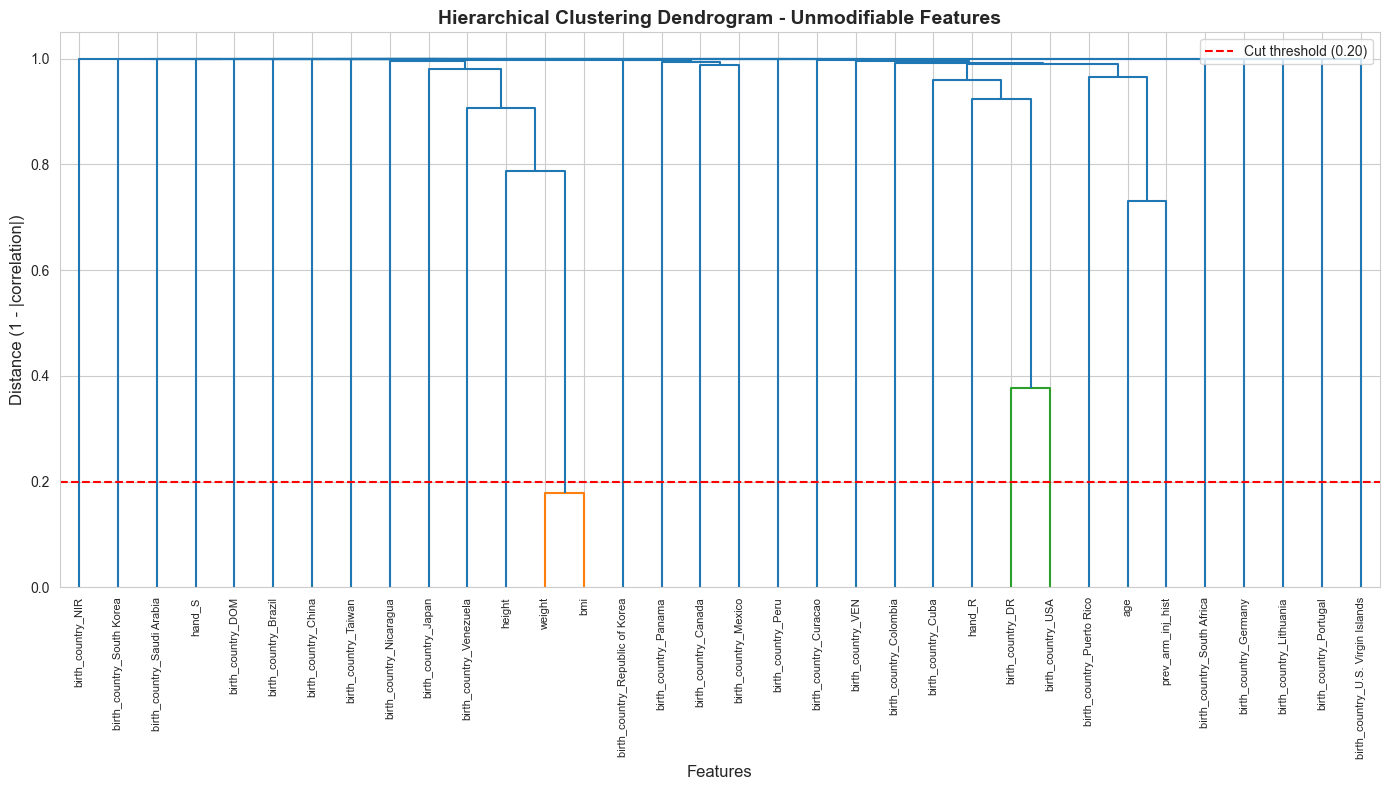


Original unmodifiable features: 7
Features after clustering: 33

Selected representatives:
  - bmi
  - height
  - birth_country_Venezuela
  - birth_country_Japan
  - birth_country_Nicaragua
  - birth_country_Canada
  - birth_country_Mexico
  - birth_country_Panama
  - birth_country_Republic of Korea
  - birth_country_Taiwan
  - birth_country_China
  - birth_country_DR
  - birth_country_USA
  - hand_R
  - birth_country_Cuba
  - age
  - prev_arm_inj_hist
  - birth_country_Puerto Rico
  - birth_country_Colombia
  - birth_country_VEN
  - birth_country_Curacao
  - birth_country_Peru
  - birth_country_Brazil
  - birth_country_DOM
  - birth_country_Germany
  - birth_country_Lithuania
  - birth_country_South Africa
  - hand_S
  - birth_country_Saudi Arabia
  - birth_country_South Korea
  - birth_country_NIR
  - birth_country_Portugal
  - birth_country_U.S. Virgin Islands


In [6]:
# Perform correlation clustering for unmodifiable features
print("Clustering unmodifiable features...")
unmod_clusters, unmod_linkage, unmod_corr = correlation_clustering(
    unmod_df, threshold=0.20, method='complete'
)

# Visualize dendrogram
plt.figure(figsize=(14, 8))
dendrogram(unmod_linkage, labels=unmod_df.columns, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram - Unmodifiable Features', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Distance (1 - |correlation|)', fontsize=12)
plt.axhline(y=0.20, color='r', linestyle='--', label='Cut threshold (0.20)')
plt.legend()
plt.tight_layout()
plt.show()

# Select cluster representatives
unmod_representatives = select_cluster_representatives(
    unmod_df, train_df['injury_next_year'], unmod_clusters
)

print(f"\nOriginal unmodifiable features: {len(unmodifiable_features)}")
print(f"Features after clustering: {len(unmod_representatives)}")
print(f"\nSelected representatives:")
for rep in unmod_representatives:
    print(f"  - {rep}")


Clustering modifiable + delta features...


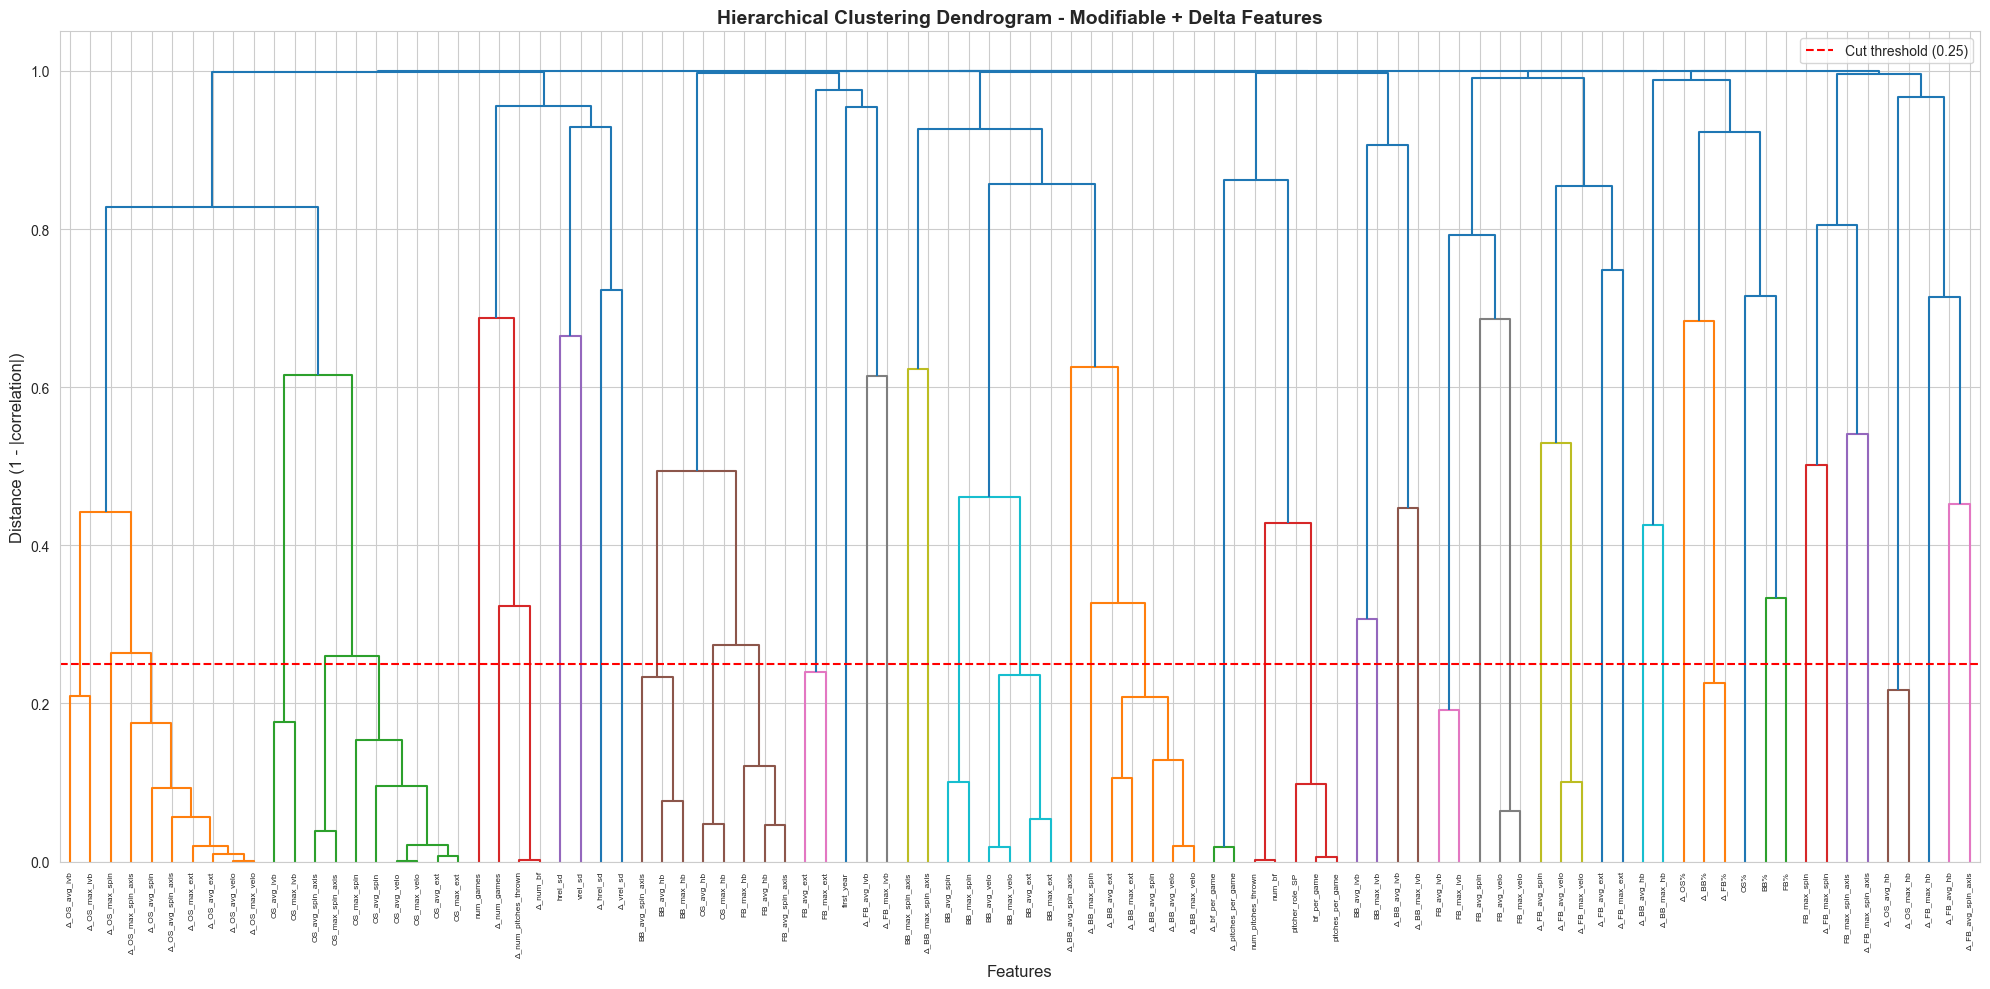


Original modifiable + delta features: 94
Features after clustering: 56

Selected representatives (first 20):
  1. Δ_OS_max_ivb
  2. Δ_OS_max_spin_axis
  3. Δ_OS_max_spin
  4. OS_max_ivb
  5. OS_max_spin_axis
  6. OS_max_spin
  7. Δ_num_bf
  8. Δ_num_games
  9. num_games
  10. hrel_sd
  11. vrel_sd
  12. Δ_hrel_sd
  13. Δ_vrel_sd
  14. BB_max_hb
  15. OS_avg_hb
  16. FB_max_hb
  17. FB_max_ext
  18. Δ_FB_avg_ivb
  19. Δ_FB_max_ivb
  20. first_year
  ... and 36 more


In [7]:
# Perform correlation clustering for modifiable + delta features
print("Clustering modifiable + delta features...")
mod_clusters, mod_linkage, mod_corr = correlation_clustering(
    mod_df, threshold=0.25, method='complete'  # Slightly higher threshold for more features
)

# Visualize dendrogram (may be large, so we'll show a subset or use a different visualization)
plt.figure(figsize=(20, 10))
dendrogram(mod_linkage, labels=mod_df.columns, leaf_rotation=90, leaf_font_size=6)
plt.title('Hierarchical Clustering Dendrogram - Modifiable + Delta Features', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Distance (1 - |correlation|)', fontsize=12)
plt.axhline(y=0.25, color='r', linestyle='--', label='Cut threshold (0.25)')
plt.legend()
plt.tight_layout()
plt.show()

# Select cluster representatives
mod_representatives = select_cluster_representatives(
    mod_df, train_df['injury_next_year'], mod_clusters
)

print(f"\nOriginal modifiable + delta features: {len(mod_features)}")
print(f"Features after clustering: {len(mod_representatives)}")
print(f"\nSelected representatives (first 20):")
for i, rep in enumerate(mod_representatives[:20]):
    print(f"  {i+1}. {rep}")
if len(mod_representatives) > 20:
    print(f"  ... and {len(mod_representatives) - 20} more")


## Step 2: Stability Selection with LASSO


In [9]:
def stability_selection_lasso(X, y, n_bootstrap=100, alpha_range=None, stability_threshold=0.6):
    """
    Perform stability selection with LASSO across bootstrap samples.
    
    Parameters:
    - X: Feature matrix (standardized)
    - y: Target variable
    - n_bootstrap: Number of bootstrap samples
    - alpha_range: Range of regularization parameters to try
    - stability_threshold: Minimum selection frequency to retain feature
    
    Returns:
    - selection_frequencies: Dictionary of feature -> selection frequency
    - selected_features: List of features with frequency >= threshold
    """
    if alpha_range is None:
        # Use a range of alpha values, find best via cross-validation
        from sklearn.linear_model import LogisticRegressionCV
        lr_cv = LogisticRegressionCV(
            Cs=10, penalty='l1', solver='liblinear', cv=5, 
            scoring='neg_log_loss', max_iter=1000
        )
        lr_cv.fit(X, y)
        best_alpha = 1.0 / lr_cv.C_[0]
        alpha_range = [best_alpha * 0.5, best_alpha, best_alpha * 2.0]
    
    selection_counts = {col: 0 for col in X.columns}
    
    print(f"Running stability selection with {n_bootstrap} bootstrap samples...")
    for i in range(n_bootstrap):
        if (i + 1) % 20 == 0:
            print(f"  Completed {i + 1}/{n_bootstrap} samples...")
        
        # Bootstrap sample
        X_boot, y_boot = resample(X, y, random_state=i)
        
        # Try different alpha values
        for alpha in alpha_range:
            lasso = LogisticRegression(
                penalty='l1', C=1.0/alpha, solver='liblinear', 
                max_iter=1000, random_state=42
            )
            lasso.fit(X_boot, y_boot)
            
            # Count selected features (non-zero coefficients)
            selected = X.columns[lasso.coef_[0] != 0]
            for feat in selected:
                selection_counts[feat] += 1
    
    # Convert to frequencies
    selection_frequencies = {k: v / (n_bootstrap * len(alpha_range)) 
                            for k, v in selection_counts.items()}
    
    # Select features above threshold
    selected_features = [feat for feat, freq in selection_frequencies.items() 
                        if freq >= stability_threshold]
    
    return selection_frequencies, selected_features

print("Stability selection function defined!")


Stability selection function defined!


STABILITY SELECTION: Unmodifiable Features
Running stability selection with 50 bootstrap samples...
  Completed 20/50 samples...
  Completed 40/50 samples...


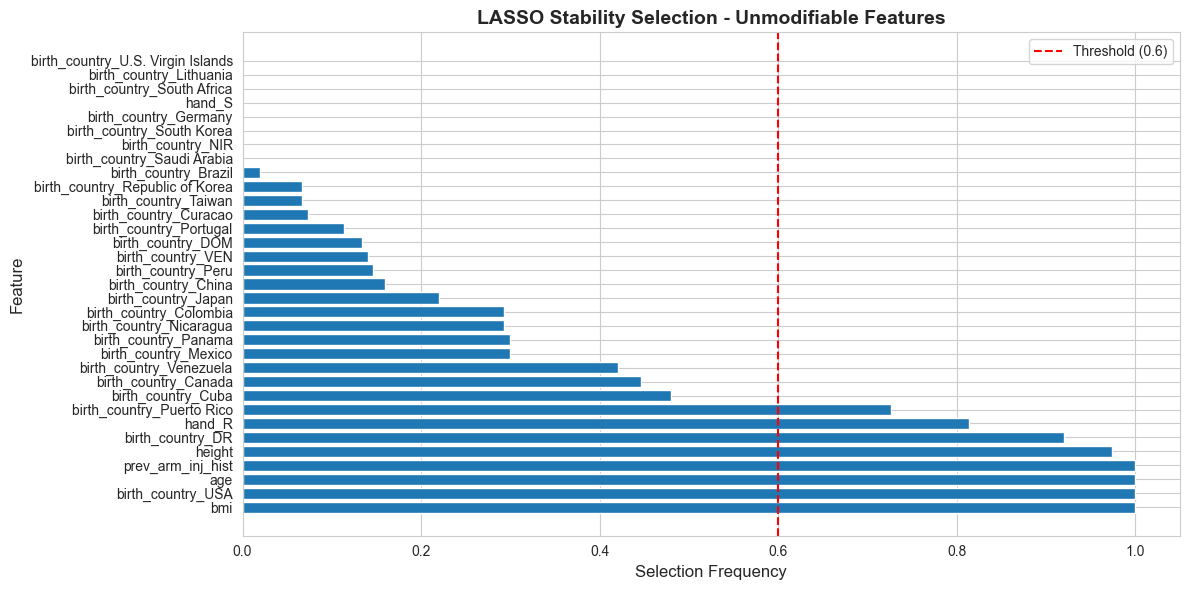


Features selected (frequency >= 0.6): 8
  - bmi: 1.000
  - height: 0.973
  - birth_country_DR: 0.920
  - birth_country_USA: 1.000
  - hand_R: 0.813
  - age: 1.000
  - prev_arm_inj_hist: 1.000
  - birth_country_Puerto Rico: 0.727


In [10]:
# Stability selection for unmodifiable features
print("=" * 60)
print("STABILITY SELECTION: Unmodifiable Features")
print("=" * 60)

X_unmod = unmod_df[unmod_representatives]
y = train_df['injury_next_year'].values

unmod_stability_freq, unmod_stability_selected = stability_selection_lasso(
    X_unmod, y, n_bootstrap=50, stability_threshold=0.6
)

# Visualize selection frequencies
plt.figure(figsize=(12, 6))
freq_df = pd.DataFrame({
    'Feature': list(unmod_stability_freq.keys()),
    'Selection Frequency': list(unmod_stability_freq.values())
}).sort_values('Selection Frequency', ascending=False)

plt.barh(freq_df['Feature'], freq_df['Selection Frequency'])
plt.axvline(x=0.6, color='r', linestyle='--', label='Threshold (0.6)')
plt.xlabel('Selection Frequency', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('LASSO Stability Selection - Unmodifiable Features', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nFeatures selected (frequency >= 0.6): {len(unmod_stability_selected)}")
for feat in unmod_stability_selected:
    print(f"  - {feat}: {unmod_stability_freq[feat]:.3f}")


STABILITY SELECTION: Modifiable + Delta Features
Running stability selection with 50 bootstrap samples...
  Completed 20/50 samples...
  Completed 40/50 samples...


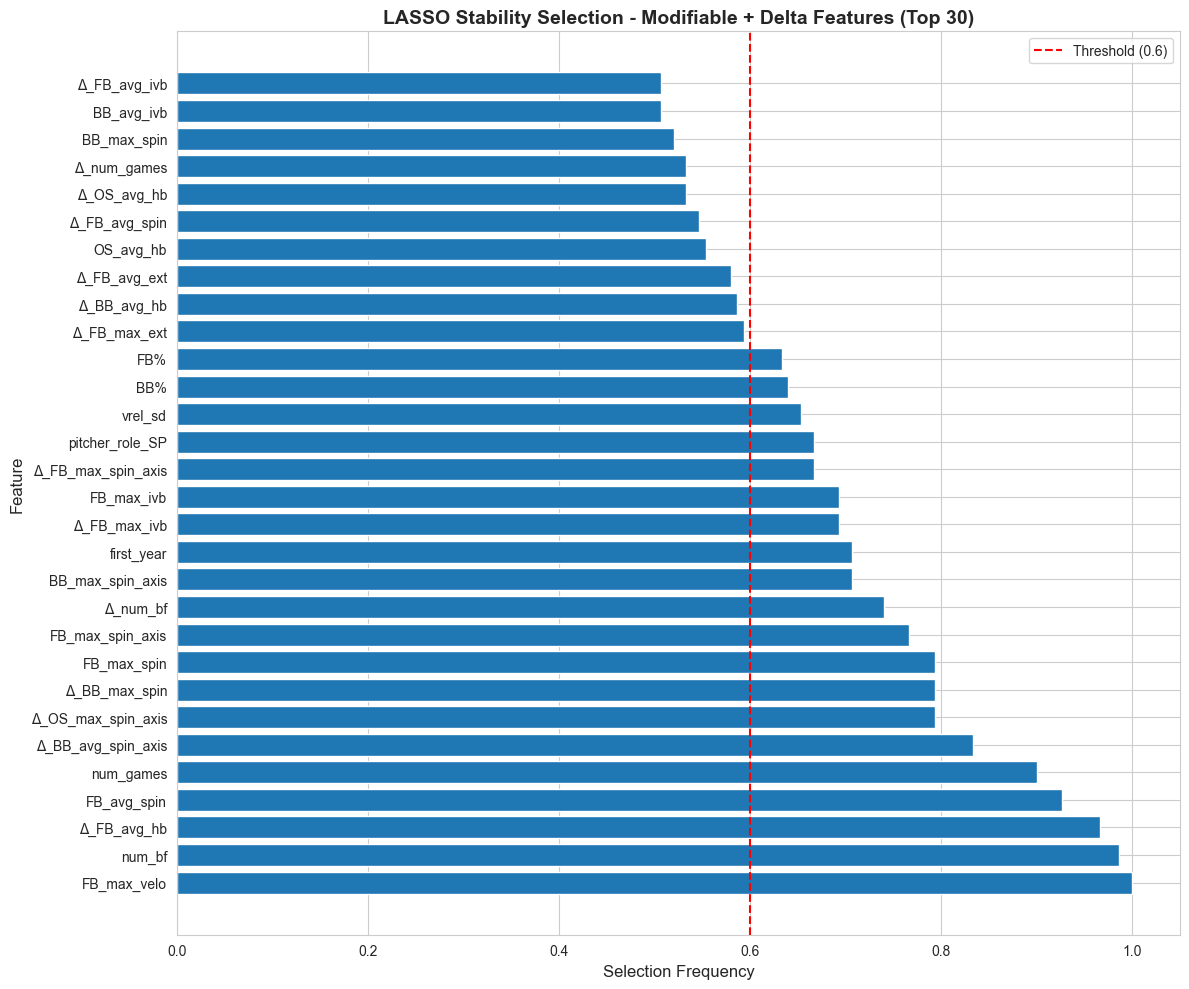


Features selected (frequency >= 0.6): 20

Top 20 selected features:
  1. FB_max_velo: 1.000
  2. num_bf: 0.987
  3. Δ_FB_avg_hb: 0.967
  4. FB_avg_spin: 0.927
  5. num_games: 0.900
  6. Δ_BB_avg_spin_axis: 0.833
  7. Δ_OS_max_spin_axis: 0.793
  8. Δ_BB_max_spin: 0.793
  9. FB_max_spin: 0.793
  10. FB_max_spin_axis: 0.767
  11. Δ_num_bf: 0.740
  12. first_year: 0.707
  13. BB_max_spin_axis: 0.707
  14. Δ_FB_max_ivb: 0.693
  15. FB_max_ivb: 0.693
  16. pitcher_role_SP: 0.667
  17. Δ_FB_max_spin_axis: 0.667
  18. vrel_sd: 0.653
  19. BB%: 0.640
  20. FB%: 0.633


In [12]:
# Stability selection for modifiable + delta features
print("=" * 60)
print("STABILITY SELECTION: Modifiable + Delta Features")
print("=" * 60)

X_mod = mod_df[mod_representatives]
y = train_df['injury_next_year'].values

mod_stability_freq, mod_stability_selected = stability_selection_lasso(
    X_mod, y, n_bootstrap=50, stability_threshold=0.6
)

# Visualize selection frequencies (top 30)
plt.figure(figsize=(12, 10))
freq_df = pd.DataFrame({
    'Feature': list(mod_stability_freq.keys()),
    'Selection Frequency': list(mod_stability_freq.values())
}).sort_values('Selection Frequency', ascending=False).head(30)

plt.barh(freq_df['Feature'], freq_df['Selection Frequency'])
plt.axvline(x=0.6, color='r', linestyle='--', label='Threshold (0.6)')
plt.xlabel('Selection Frequency', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('LASSO Stability Selection - Modifiable + Delta Features (Top 30)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nFeatures selected (frequency >= 0.6): {len(mod_stability_selected)}")
print("\nTop 20 selected features:")
for i, feat in enumerate(sorted(mod_stability_selected, 
                                key=lambda x: mod_stability_freq[x], 
                                reverse=True)[:20]):
    print(f"  {i+1}. {feat}: {mod_stability_freq[feat]:.3f}")
if len(mod_stability_selected) > 20:
    print(f"  ... and {len(mod_stability_selected) - 20} more")


## Step 3: Permutation Importance with XGBoost


In [13]:
def xgboost_permutation_importance(X, y, n_repeats=10, random_state=42):
    """
    Compute permutation importance using XGBoost.
    
    Parameters:
    - X: Feature matrix
    - y: Target variable
    - n_repeats: Number of times to permute each feature
    - random_state: Random seed
    
    Returns:
    - importance_dict: Dictionary of feature -> importance score
    """
    # Train XGBoost model
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=random_state,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    xgb_model.fit(X, y)
    
    # Compute permutation importance
    perm_importance = permutation_importance(
        xgb_model, X, y, 
        n_repeats=n_repeats, 
        random_state=random_state,
        scoring='neg_log_loss'
    )
    
    # Create dictionary
    importance_dict = {
        feature: perm_importance.importances_mean[i] 
        for i, feature in enumerate(X.columns)
    }
    
    return importance_dict, xgb_model

print("XGBoost permutation importance function defined!")


XGBoost permutation importance function defined!


PERMUTATION IMPORTANCE: Unmodifiable Features


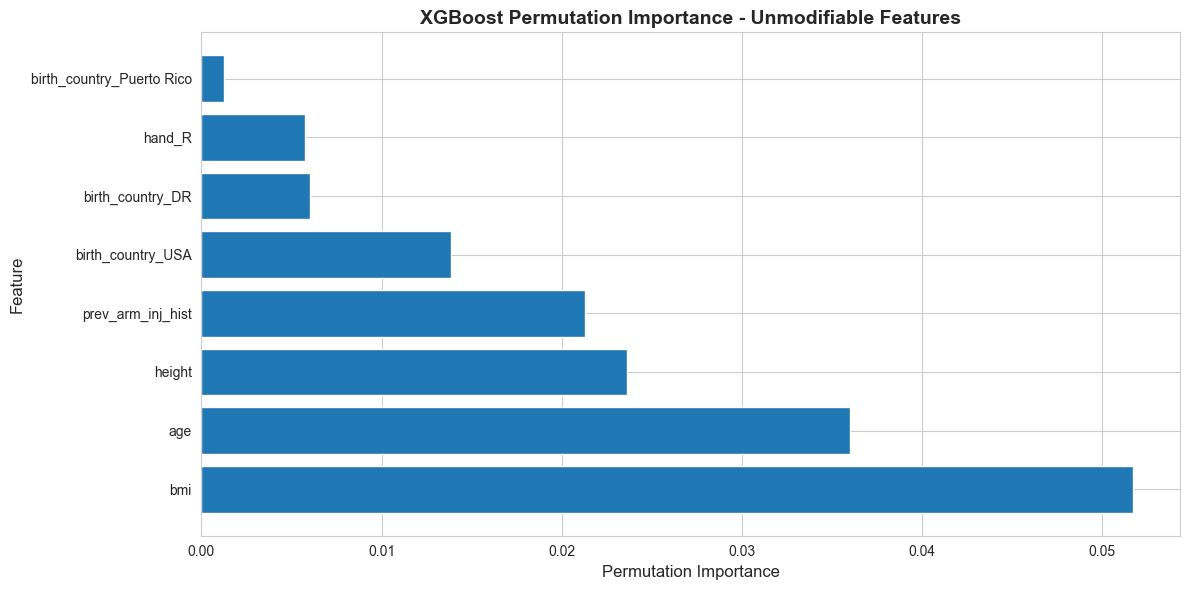


Top features by permutation importance:
  1. bmi: 0.0517
  2. age: 0.0360
  3. height: 0.0236
  4. prev_arm_inj_hist: 0.0213
  5. birth_country_USA: 0.0139
  6. birth_country_DR: 0.0060
  7. hand_R: 0.0058
  8. birth_country_Puerto Rico: 0.0013


In [14]:
# Permutation importance for unmodifiable features
print("=" * 60)
print("PERMUTATION IMPORTANCE: Unmodifiable Features")
print("=" * 60)

X_unmod_perm = unmod_df[unmod_stability_selected] if len(unmod_stability_selected) > 0 else unmod_df[unmod_representatives]
y = train_df['injury_next_year'].values

unmod_perm_importance, unmod_xgb = xgboost_permutation_importance(
    X_unmod_perm, y, n_repeats=10
)

# Visualize permutation importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'Feature': list(unmod_perm_importance.keys()),
    'Importance': list(unmod_perm_importance.values())
}).sort_values('Importance', ascending=False)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('XGBoost Permutation Importance - Unmodifiable Features', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop features by permutation importance:")
for i, (feat, imp) in enumerate(sorted(unmod_perm_importance.items(), 
                                      key=lambda x: x[1], 
                                      reverse=True)[:10]):
    print(f"  {i+1}. {feat}: {imp:.4f}")


PERMUTATION IMPORTANCE: Modifiable + Delta Features


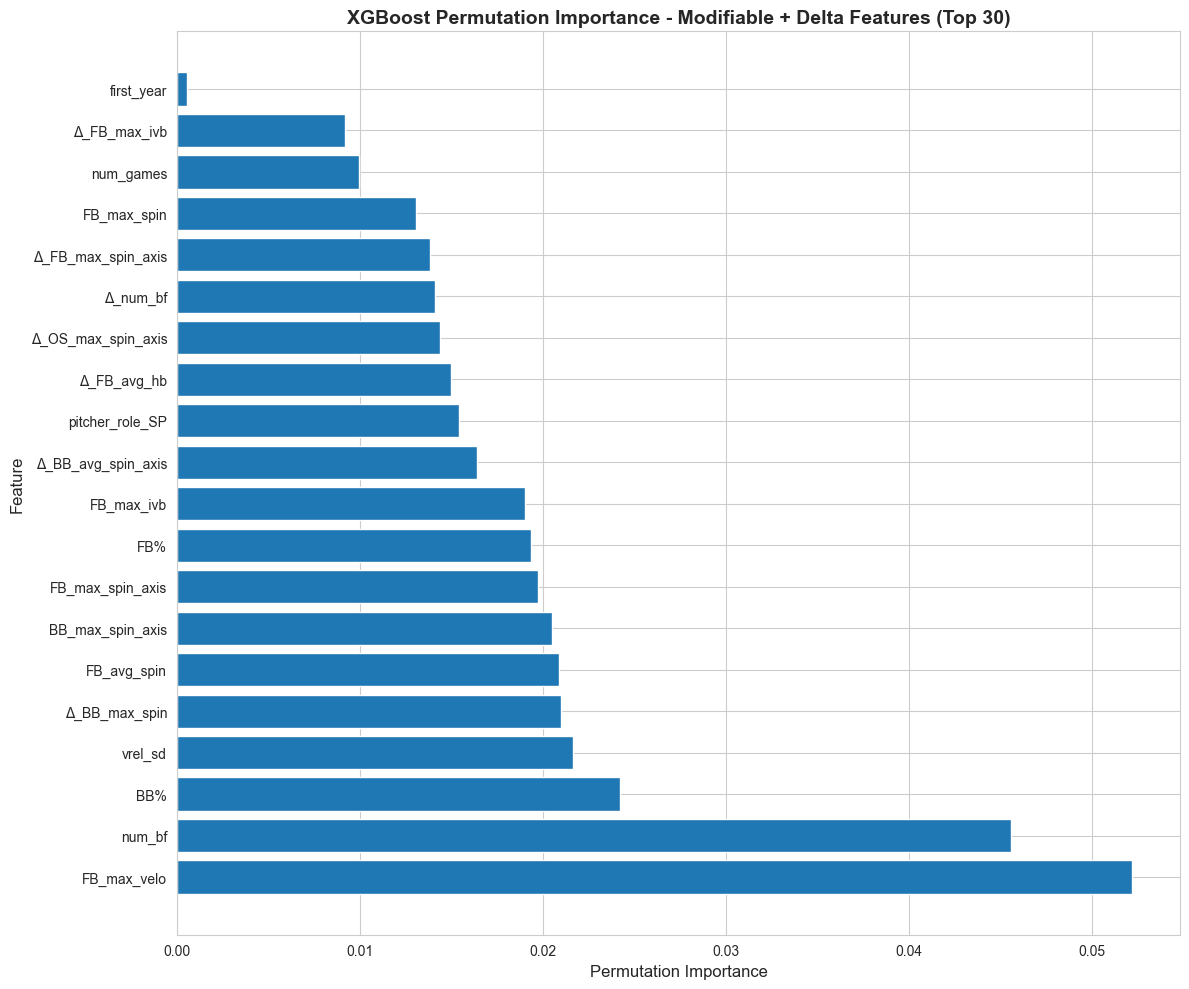


Top 20 features by permutation importance:
  1. FB_max_velo: 0.0522
  2. num_bf: 0.0456
  3. BB%: 0.0242
  4. vrel_sd: 0.0217
  5. Δ_BB_max_spin: 0.0210
  6. FB_avg_spin: 0.0209
  7. BB_max_spin_axis: 0.0205
  8. FB_max_spin_axis: 0.0197
  9. FB%: 0.0193
  10. FB_max_ivb: 0.0190
  11. Δ_BB_avg_spin_axis: 0.0164
  12. pitcher_role_SP: 0.0154
  13. Δ_FB_avg_hb: 0.0150
  14. Δ_OS_max_spin_axis: 0.0144
  15. Δ_num_bf: 0.0141
  16. Δ_FB_max_spin_axis: 0.0138
  17. FB_max_spin: 0.0131
  18. num_games: 0.0099
  19. Δ_FB_max_ivb: 0.0092
  20. first_year: 0.0005


In [15]:
# Permutation importance for modifiable + delta features
print("=" * 60)
print("PERMUTATION IMPORTANCE: Modifiable + Delta Features")
print("=" * 60)

X_mod_perm = mod_df[mod_stability_selected] if len(mod_stability_selected) > 0 else mod_df[mod_representatives]
y = train_df['injury_next_year'].values

mod_perm_importance, mod_xgb = xgboost_permutation_importance(
    X_mod_perm, y, n_repeats=10
)

# Visualize permutation importance (top 30)
plt.figure(figsize=(12, 10))
importance_df = pd.DataFrame({
    'Feature': list(mod_perm_importance.keys()),
    'Importance': list(mod_perm_importance.values())
}).sort_values('Importance', ascending=False).head(30)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('XGBoost Permutation Importance - Modifiable + Delta Features (Top 30)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 20 features by permutation importance:")
for i, (feat, imp) in enumerate(sorted(mod_perm_importance.items(), 
                                      key=lambda x: x[1], 
                                      reverse=True)[:20]):
    print(f"  {i+1}. {feat}: {imp:.4f}")


## Step 4: Finalize Feature Sets


In [ ]:
def finalize_features(cluster_reps, stability_selected, perm_importance, 
                     stability_freq_dict=None, perm_top_n=None, min_methods=2):
    """
    Combine results from clustering, LASSO stability, and permutation importance.
    
    Parameters:
    - cluster_reps: Features selected from clustering
    - stability_selected: List of features selected by LASSO stability
    - perm_importance: Dictionary of permutation importance scores
    - stability_freq_dict: Dictionary of feature -> stability frequency (optional)
    - perm_top_n: Number of top features by permutation importance to consider
    - min_methods: Minimum number of methods that must select a feature
    
    Returns:
    - final_features: List of finalized features
    - selection_summary: DataFrame with selection details
    """
    # Determine top features by permutation importance
    if perm_top_n is None:
        # Use features with positive importance
        perm_selected = [f for f, imp in perm_importance.items() if imp > 0]
    else:
        perm_selected = sorted(perm_importance.items(), key=lambda x: x[1], reverse=True)[:perm_top_n]
        perm_selected = [f for f, _ in perm_selected]
    
    # Get all candidate features
    all_candidates = set(cluster_reps) | set(stability_selected) | set(perm_selected)
    
    # Score each feature
    selection_scores = []
    for feat in all_candidates:
        in_cluster = 1 if feat in cluster_reps else 0
        in_stability = 1 if feat in stability_selected else 0
        in_perm = 1 if feat in perm_selected else 0
        
        # Get stability frequency if available
        if stability_freq_dict is not None:
            stability_freq = stability_freq_dict.get(feat, 0)
        else:
            stability_freq = 0
        
        # Get permutation importance if available
        perm_imp = perm_importance.get(feat, 0)
        
        # Count methods
        method_count = in_cluster + in_stability + in_perm
        
        # Combined score
        score = (method_count * 10 + 
                stability_freq * 5 +
                perm_imp * 100)
        
        selection_scores.append({
            'feature': feat,
            'in_cluster': in_cluster,
            'in_stability': in_stability,
            'in_perm': in_perm,
            'method_count': method_count,
            'stability_freq': stability_freq,
            'perm_importance': perm_imp,
            'combined_score': score
        })
    
    selection_df = pd.DataFrame(selection_scores)
    
    # Select features that appear in at least min_methods methods
    final_features = selection_df[selection_df['method_count'] >= min_methods]['feature'].tolist()
    
    # If too few features, also include top-scoring features
    if len(final_features) < 5:
        # Include top 10 by combined score
        top_features = selection_df.nlargest(10, 'combined_score')['feature'].tolist()
        final_features = list(set(final_features + top_features))
    
    return final_features, selection_df

print("Feature finalization function defined!")


Feature finalization function defined!


In [ ]:
# Finalize unmodifiable features
print("=" * 60)
print("FINALIZING: Unmodifiable Features")
print("=" * 60)

unmod_final, unmod_summary = finalize_features(
    unmod_representatives,
    unmod_stability_selected,
    unmod_perm_importance,
    stability_freq_dict=unmod_stability_freq,
    min_methods=1  # More lenient for unmodifiable (fewer features)
)

print(f"\nFinal unmodifiable features ({len(unmod_final)}):")
for feat in sorted(unmod_final):
    print(f"  - {feat}")

# Display summary
print("\nSelection Summary:")
print(unmod_summary.sort_values('combined_score', ascending=False).to_string(index=False))


FINALIZING: Unmodifiable Features


NameError: name 'finalize_features' is not defined

In [ ]:
# Finalize modifiable + delta features
print("=" * 60)
print("FINALIZING: Modifiable + Delta Features")
print("=" * 60)

mod_final, mod_summary = finalize_features(
    mod_representatives,
    mod_stability_selected,
    mod_perm_importance,
    stability_freq_dict=mod_stability_freq,
    perm_top_n=50,  # Consider top 50 by permutation importance
    min_methods=2   # Require at least 2 methods to agree
)

print(f"\nFinal modifiable + delta features ({len(mod_final)}):")
for i, feat in enumerate(sorted(mod_final), 1):
    print(f"  {i}. {feat}")

# Display top 30 summary
print("\nTop 30 Features by Combined Score:")
print(mod_summary.nlargest(30, 'combined_score')[['feature', 'method_count', 
                                                   'stability_freq', 'perm_importance', 
                                                   'combined_score']].to_string(index=False))


## Step 5: Visualize Final Feature Selection Results


In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Unmodifiable: Method agreement
ax1 = axes[0, 0]
unmod_methods = unmod_summary[['feature', 'in_cluster', 'in_stability', 'in_perm']].copy()
unmod_methods['total_methods'] = (unmod_methods['in_cluster'] + 
                                   unmod_methods['in_stability'] + 
                                   unmod_methods['in_perm'])
unmod_methods = unmod_methods.sort_values('total_methods', ascending=True).tail(15)
unmod_methods.set_index('feature', inplace=True)
unmod_methods[['in_cluster', 'in_stability', 'in_perm']].plot(
    kind='barh', stacked=True, ax=ax1, 
    color=['#3498db', '#e74c3c', '#2ecc71']
)
ax1.set_title('Unmodifiable Features: Method Agreement', fontweight='bold')
ax1.set_xlabel('Methods Selecting Feature')
ax1.legend(['Clustering', 'LASSO Stability', 'Permutation Importance'])

# 2. Modifiable: Method agreement (top 20)
ax2 = axes[0, 1]
mod_methods = mod_summary[['feature', 'in_cluster', 'in_stability', 'in_perm']].copy()
mod_methods['total_methods'] = (mod_methods['in_cluster'] + 
                                 mod_methods['in_stability'] + 
                                 mod_methods['in_perm'])
mod_methods = mod_methods.sort_values('total_methods', ascending=True).tail(20)
mod_methods.set_index('feature', inplace=True)
mod_methods[['in_cluster', 'in_stability', 'in_perm']].plot(
    kind='barh', stacked=True, ax=ax2,
    color=['#3498db', '#e74c3c', '#2ecc71']
)
ax2.set_title('Modifiable Features: Method Agreement (Top 20)', fontweight='bold')
ax2.set_xlabel('Methods Selecting Feature')
ax2.legend(['Clustering', 'LASSO Stability', 'Permutation Importance'])

# 3. Unmodifiable: Combined scores
ax3 = axes[1, 0]
unmod_top = unmod_summary.nlargest(10, 'combined_score')
ax3.barh(unmod_top['feature'], unmod_top['combined_score'])
ax3.set_title('Unmodifiable Features: Top 10 by Combined Score', fontweight='bold')
ax3.set_xlabel('Combined Score')

# 4. Modifiable: Combined scores (top 20)
ax4 = axes[1, 1]
mod_top = mod_summary.nlargest(20, 'combined_score')
ax4.barh(mod_top['feature'], mod_top['combined_score'])
ax4.set_title('Modifiable Features: Top 20 by Combined Score', fontweight='bold')
ax4.set_xlabel('Combined Score')

plt.tight_layout()
plt.show()


## Step 6: Save Selected Features


In [ ]:
# Map back to original feature names (handle one-hot encoded features)
def map_to_original_features(selected_features, original_feature_list):
    """
    Map selected features back to original feature names.
    Handles one-hot encoded categorical variables.
    """
    original_selected = []
    
    for feat in selected_features:
        # Check if it's a one-hot encoded feature
        if any(feat.startswith(orig + '_') for orig in original_feature_list):
            # Extract base feature name
            for orig in original_feature_list:
                if feat.startswith(orig + '_'):
                    if orig not in original_selected:
                        original_selected.append(orig)
                    break
        elif feat in original_feature_list:
            original_selected.append(feat)
        else:
            # Keep as is (might be a transformed feature)
            original_selected.append(feat)
    
    return list(set(original_selected))

# Map unmodifiable features
unmod_final_original = map_to_original_features(unmod_final, unmodifiable_features)

# Map modifiable features (need to handle both modifiable and delta)
all_mod_features = modifiable_features + delta_features
mod_final_original = map_to_original_features(mod_final, all_mod_features)

# Create final feature sets for each model variant
variant1_features = unmod_final_original.copy()  # Unmodifiable only
variant2_features = mod_final_original.copy()    # Modifiable + delta only
variant3_features = unmod_final_original + mod_final_original  # All features

# Ensure 'game_year' is included for all variants (needed for year term)
variant1_features.append('game_year')
variant2_features.append('game_year')
variant3_features.append('game_year')

# Remove duplicates
variant1_features = list(set(variant1_features))
variant2_features = list(set(variant2_features))
variant3_features = list(set(variant3_features))

print("=" * 60)
print("FINAL FEATURE SETS")
print("=" * 60)
print(f"\nVariant 1 (Unmodifiable only): {len(variant1_features)} features")
print(f"Variant 2 (Modifiable + Delta): {len(variant2_features)} features")
print(f"Variant 3 (All features): {len(variant3_features)} features")

# Save to dictionaries for easy access
feature_selection_results = {
    'variant1_unmodifiable': variant1_features,
    'variant2_modifiable': variant2_features,
    'variant3_all': variant3_features,
    'unmodifiable_cluster_reps': unmod_representatives,
    'modifiable_cluster_reps': mod_representatives,
    'unmodifiable_stability_selected': unmod_stability_selected,
    'modifiable_stability_selected': mod_stability_selected,
    'unmodifiable_perm_top': sorted(unmod_perm_importance.items(), 
                                    key=lambda x: x[1], reverse=True)[:10],
    'modifiable_perm_top': sorted(mod_perm_importance.items(), 
                                  key=lambda x: x[1], reverse=True)[:20],
    'unmodifiable_summary': unmod_summary,
    'modifiable_summary': mod_summary
}

# Print feature lists
print("\n" + "=" * 60)
print("VARIANT 1 FEATURES (Unmodifiable only):")
print("=" * 60)
for i, feat in enumerate(sorted(variant1_features), 1):
    print(f"{i}. {feat}")

print("\n" + "=" * 60)
print("VARIANT 2 FEATURES (Modifiable + Delta):")
print("=" * 60)
for i, feat in enumerate(sorted(variant2_features), 1):
    print(f"{i}. {feat}")

print("\n" + "=" * 60)
print("VARIANT 3 FEATURES (All):")
print("=" * 60)
print(f"Total: {len(variant3_features)} features")
print("(Combination of Variant 1 + Variant 2)")

# Save results to a pickle file for later use
import pickle
with open('feature_selection_results.pkl', 'wb') as f:
    pickle.dump(feature_selection_results, f)

print("\n✓ Feature selection results saved to 'feature_selection_results.pkl'")
